In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import TFAutoModel, AutoTokenizer

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the ChemBERTa tokenizer
chemberta_model_name = "DeepChem/ChemBERTa-77M-MLM"
tokenizer = AutoTokenizer.from_pretrained(chemberta_model_name)

# Function to tokenize SMILES strings
def tokenize_smiles(smiles_list):
    return tokenizer(smiles_list, padding=True, truncation=True, return_tensors="tf")

# Define ChemBERTa Model inside TensorFlow
class ChemBERTaModel(keras.Model):
    def __init__(self, chemberta_model_name, aggregation="sum"):
        super(ChemBERTaModel, self).__init__()
        self.chemberta = TFAutoModel.from_pretrained(chemberta_model_name, trainable=True)  # Make it trainable
        self.aggregation = aggregation  # Aggregation method

        # Post-aggregation MLP
        self.mlp = keras.Sequential([
            layers.Dense(256, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(128, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(4, activation="linear")  # Predicts 4 properties (BetaT, GammaT, GammaT, GammaV)
        ])

    def call(self, inputs):
        input_1, input_2 = inputs  # SMILES for both molecules
        
        # Get ChemBERTa embeddings
        emb_1 = self.chemberta(input_1)["last_hidden_state"][:, 0, :]  # CLS token embedding
        emb_2 = self.chemberta(input_2)["last_hidden_state"][:, 0, :]  # CLS token embedding

        # Aggregate embeddings
        if self.aggregation == "sum":
            agg = emb_1 + emb_2
        elif self.aggregation == "mean":
            agg = (emb_1 + emb_2) / 2
        elif self.aggregation == "max":
            agg = tf.maximum(emb_1, emb_2)
        else:
            raise ValueError("Invalid aggregation method")

        # Pass through MLP to predict properties
        output = self.mlp(agg)
       


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("split_smiles.csv")  # Ensure your dataset has SMILES strings & targets

# Extract SMILES and target properties
smiles_1 = df["SMILES_part1"].tolist()
smiles_2 = df["SMILES_part2"].tolist()
y = df[["BetaT", "GammaT", "BetaV", "GammaV"]].values  # Multi-target regression

# Split into train (80%), validation (10%), and test (10%)
smiles_1_train, smiles_1_temp, smiles_2_train, smiles_2_temp, y_train, y_temp = train_test_split(
    smiles_1, smiles_2, y, test_size=0.2, random_state=42
)
smiles_1_val, smiles_1_test, smiles_2_val, smiles_2_test, y_val, y_test = train_test_split(
    smiles_1_temp, smiles_2_temp, y_temp, test_size=0.5, random_state=42
)

# Tokenize SMILES strings
X1_train, X2_train = tokenize_smiles(smiles_1_train), tokenize_smiles(smiles_2_train)
X1_val, X2_val = tokenize_smiles(smiles_1_val), tokenize_smiles(smiles_2_val)
X1_test, X2_test = tokenize_smiles(smiles_1_test), tokenize_smiles(smiles_2_test)


In [5]:
# Initialize model
model = ChemBERTaModel(chemberta_model_name, aggregation="sum")

# Compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=2e-5), loss="mse", metrics=["mae"])

# Train model with validation set
history = model.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_val, X2_val], y_val),
    epochs=5,  # Start with fewer epochs to monitor performance
    batch_size=8  # Keep small batch size for transformer-based models
)


OSError: DeepChem/ChemBERTa-77M-MLM does not appear to have a file named tf_model.h5 but there is a file for PyTorch weights. Use `from_pt=True` to load this model from those weights.

In [ ]:
 import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Predict on test set
y_pred = model.predict([X1_test, X2_test])

# Convert predictions and ground truth to NumPy arrays
y_true = y_test  # Already a NumPy array
y_pred = np.array(y_pred)  # Ensure predictions are NumPy

# Define target names
target_columns = ["BetaT", "GammaT", "BetaV", "GammaV"]

# Compute RMSE for each target
rmse_values = {}
for i, target in enumerate(target_columns):
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))  # RMSE Calculation
    rmse_values[target] = rmse
    print(f"RMSE for {target}: {rmse:.4f}")

# Parity Plots
plt.figure(figsize=(12, 8))

for i, target in enumerate(target_columns):
    plt.subplot(2, 2, i + 1)  # 2x2 subplot layout
    plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([min(y_true[:, i]), max(y_true[:, i])], 
             [min(y_true[:, i]), max(y_true[:, i])], 
             color="red", linestyle="--")  # Diagonal parity line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Parity Plot for {target}")

plt.tight_layout()
plt.show()

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("chemberta_features.csv")  # Ensure the dataset has embeddings & target

# Extract embeddings for each molecule
X1 = df[[f"feat_1_{i}" for i in range(384)]].values  # First molecule embedding
X2 = df[[f"feat_2_{i}" for i in range(384)]].values  # Second molecule embedding
y = df[["BetaT","GammaT", "BetaV", "GammaV"]].values  # Replace with actual target property

# First, split into 80% training and 20% temporary (validation + test)
X1_train, X1_temp, X2_train, X2_temp, y_train, y_temp = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

# Then, split the remaining 20% into 10% validation and 10% test
X1_val, X1_test, X2_val, X2_test, y_val, y_test = train_test_split(X1_temp, X2_temp, y_temp, test_size=0.5, random_state=42)
                                                                   
# Convert to NumPy arrays (needed for TensorFlow)
X1_train, X2_train, y_train = np.array(X1_train), np.array(X2_train), np.array(y_train)
X1_val, X2_val, y_val = np.array(X1_val), np.array(X2_val), np.array(y_val)
X1_test, X2_test, y_test = np.array(X1_test), np.array(X2_test), np.array(y_test)


In [2]:
# Define input layers (Ensure input_dim matches your embeddings)
input_dim = 384  # This should match the size of ChemBERTa embeddings

input_1 = keras.Input(shape=(input_dim,))
input_2 = keras.Input(shape=(input_dim,))

# Sum aggregation
agg = layers.Add()([input_1, input_2])

# Final prediction layers (MLP)
output = layers.Dense(128, activation="relu")(agg)
output = layers.BatchNormalization()(output)  # Normalize before next layer
output = layers.Dense(64, activation="relu")(output)
output = layers.BatchNormalization()(output)  # Normalize before final layer
output = layers.Dense(4, activation="linear")(output)  # Regression output

# Create model
model = keras.Model(inputs=[input_1, input_2], outputs=output)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"])


In [3]:
# Train model
batch_size = 32
epochs = 100

history = model.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_val, X2_val], y_val),
    epochs=epochs,
    batch_size=batch_size
)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8998 - mae: 1.1410 - val_loss: 0.8944 - val_mae: 0.8613
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0360 - mae: 0.9059 - val_loss: 0.7431 - val_mae: 0.7825
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7376 - mae: 0.7898 - val_loss: 0.6594 - val_mae: 0.7277
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5609 - mae: 0.6860 - val_loss: 0.5629 - val_mae: 0.6571
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4032 - mae: 0.5808 - val_loss: 0.4558 - val_mae: 0.5729
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2716 - mae: 0.4623 - val_loss: 0.3341 - val_mae: 0.4761
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1806 - mae: 0.3616 - val_loss: 0.2168 - val_mae: 0.3760
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1121 - mae: 0.2742 - val_loss: 0.1775 - val_mae: 0.3401
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.078

In [4]:
# Evaluate on test set
y_pred = model.predict([X1_test, X2_test])

# Convert tensors to NumPy arrays
y_true = y_test.flatten()
y_pred_f = y_pred.flatten()

# Compute evaluation metrics
mae = mean_absolute_error(y_true, y_pred_f)
mse = mean_squared_error(y_true, y_pred_f)
r2 = r2_score(y_true, y_pred_f)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Mean Absolute Error (MAE): 0.0525
Mean Squared Error (MSE): 0.0059
R² Score: 0.4786


In [5]:
# Define target names
target_columns = ["BetaT", "GammaT", "BetaV", "GammaV"]

# Compute RMSE for each target individually
rmse_values = {}
for i, target in enumerate(target_columns):
    rmse = np.sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))  # RMSE Calculation
    rmse_values[target] = rmse
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    print(f"RMSE for {target}: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

RMSE for BetaT: 0.0553
R² Score: -3.3210
RMSE for GammaT: 0.0963
R² Score: 0.7695
RMSE for BetaV: 0.0584
R² Score: -4236.3078
RMSE for GammaV: 0.0877
R² Score: -2.0254


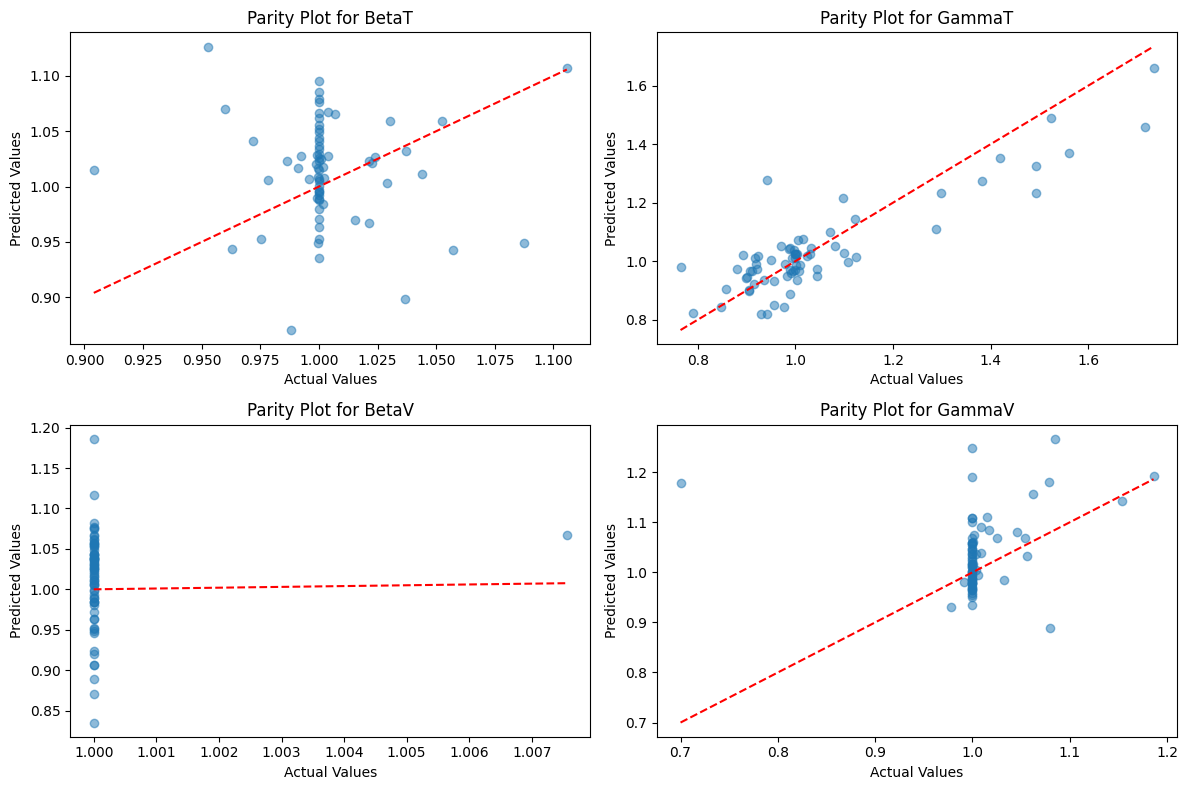

In [6]:
import matplotlib.pyplot as plt

# Create parity plots
plt.figure(figsize=(12, 8))

for i, target in enumerate(target_columns):
    plt.subplot(2, 2, i + 1)  # 2x2 subplot layout
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([min(y_test[:, i]), max(y_test[:, i])], 
             [min(y_test[:, i]), max(y_test[:, i])], 
             color="red", linestyle="--")  # Diagonal parity line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Parity Plot for {target}")

plt.tight_layout()
plt.show()
